In [ ]:
import kagglehub


path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\yun\.cache\kagglehub\datasets\teejmahal20\airline-passenger-satisfaction\versions\1


In [2]:
import pandas as pd
import os
csv_file_path = os.path.join(path, 'train.csv')
df = pd.read_csv(csv_file_path)
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
# 1. 결측치 확인
print(df.isnull().sum())


Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [5]:
# 1. 결측치가 있는 행(Row) 제거
df.dropna(subset=['Arrival Delay in Minutes'], inplace=True)
# 2. 잘 지워졌는지 확인 (0이 나와야 함)
print("제거 후 결측치 수:", df['Arrival Delay in Minutes'].isnull().sum())

# 3. 타겟 변수(만족도) 숫자화 (분석 편의를 위해 미리 변환)
# satisfied -> 1, neutral or dissatisfied -> 0
df['satisfaction_binary'] = df['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0)

print("전처리 완료! 남은 데이터 개수:", len(df))

제거 후 결측치 수: 0
전처리 완료! 남은 데이터 개수: 103594


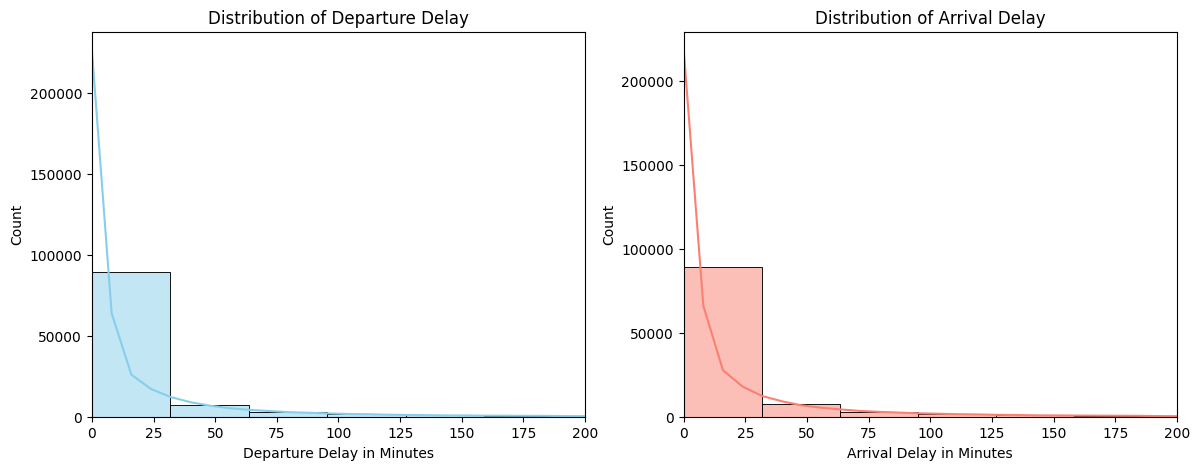

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 출발 지연과 도착 지연의 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Departure Delay in Minutes'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Departure Delay')
axes[0].set_xlim(0, 200) # 200분 이상은 너무 적어서 줌인

sns.histplot(df['Arrival Delay in Minutes'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Arrival Delay')
axes[1].set_xlim(0, 200)

plt.show()

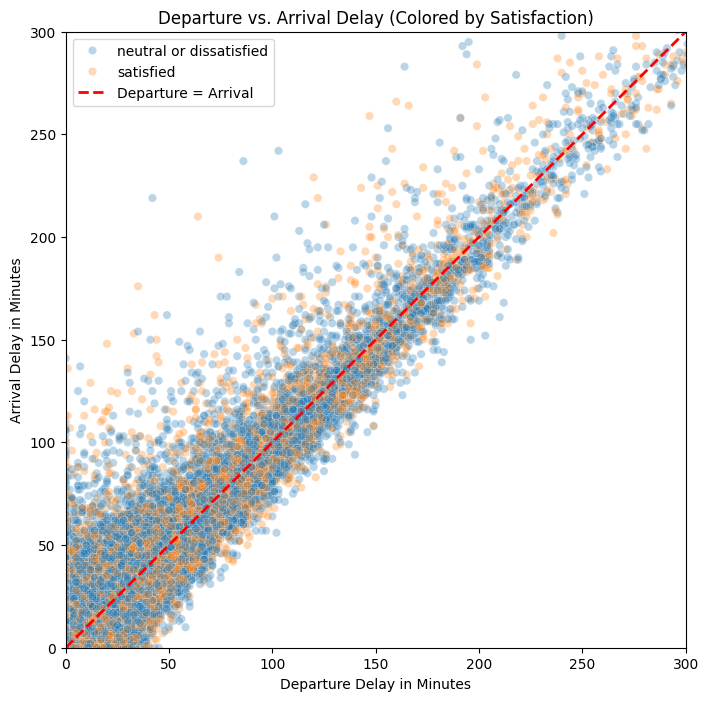

In [8]:
plt.figure(figsize=(8, 8))

# 산점도 그리기
sns.scatterplot(x='Departure Delay in Minutes', y='Arrival Delay in Minutes', 
                hue='satisfaction', data=df, alpha=0.3)

# y=x 기준선 그리기 (출발 지연 = 도착 지연)
plt.plot([0, 300], [0, 300], 'r--', linewidth=2, label='Departure = Arrival')

plt.title('Departure vs. Arrival Delay (Colored by Satisfaction)')
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.legend()
plt.show()

Delay_Category
1. On-Time (Best)              0.471580
2. Recovered (Made-up Time)    0.496285
3. Delayed                     0.358102
4. Worsened (Nightmare)        0.351776
5. Others                      0.422288
Name: satisfaction_binary, dtype: float64


C:\Users\yun\AppData\Local\Temp\ipykernel_17288\593139517.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Delay_Category', y='satisfaction_binary', data=df,


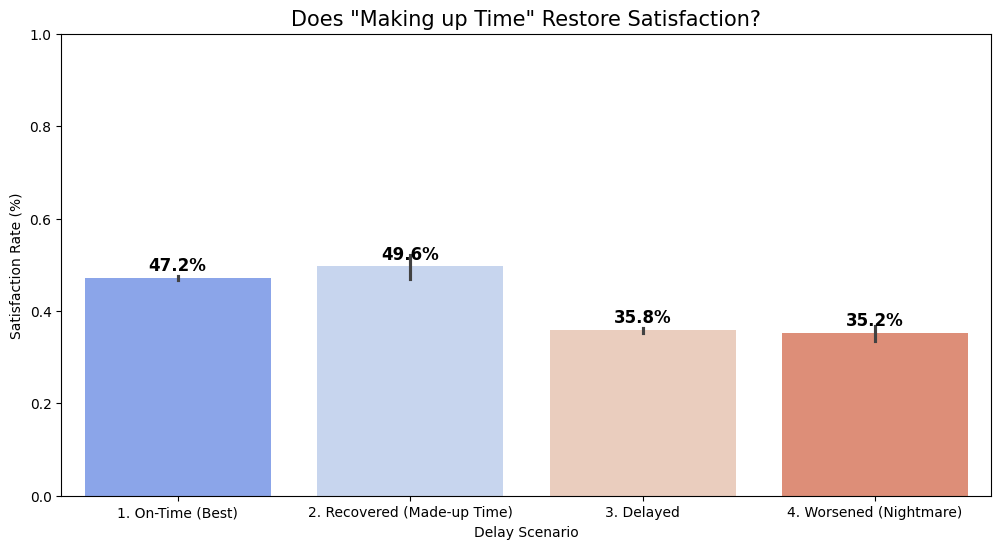

In [9]:
# 4단계: 지연 유형별 만족도 비교 (Made-up Time의 효과 검증)

def classify_delay(row):
    dep = row['Departure Delay in Minutes']
    arr = row['Arrival Delay in Minutes']
    
    # 1. 정시 운항 (지연 15분 미만은 통상 정시로 간주하지만, 엄격하게 5분으로 봅니다)
    if dep <= 5 and arr <= 5:
        return '1. On-Time (Best)'
    
    # 2. 만회된 지연 (핵심! 출발은 늦었으나 도착은 거의 정시)
    # 출발은 15분 이상 지연됐는데, 도착은 5분 이내로 세이프
    elif dep > 15 and arr <= 5:
        return '2. Recovered (Made-up Time)'
    
    # 3. 그냥 지연 (출발도 늦고 도착도 늦음)
    elif dep > 5 and arr > 5:
        return '3. Delayed'
        
    # 4. 악화된 지연 (출발보다 도착이 훨씬 늦어짐)
    elif dep <= 5 and arr > 15:
        return '4. Worsened (Nightmare)'
    
    else:
        return '5. Others'

# 분류 적용
df['Delay_Category'] = df.apply(classify_delay, axis=1)

# 시각화
plt.figure(figsize=(12, 6))

# 각 그룹별 만족도(1)의 평균(비율) 계산
satisfaction_rate = df.groupby('Delay_Category')['satisfaction_binary'].mean().sort_index()
print(satisfaction_rate) # 수치로도 확인

# 막대 그래프
ax = sns.barplot(x='Delay_Category', y='satisfaction_binary', data=df, 
                 order=['1. On-Time (Best)', '2. Recovered (Made-up Time)', '3. Delayed', '4. Worsened (Nightmare)'],
                 palette='coolwarm')

# 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), textcoords = 'offset points', fontsize=12, fontweight='bold')

plt.title('Does "Making up Time" Restore Satisfaction?', fontsize=15)
plt.ylabel('Satisfaction Rate (%)')
plt.xlabel('Delay Scenario')
plt.ylim(0, 1) # 0~100%
plt.show()

In [10]:
from scipy.stats import chi2_contingency

# 1. 각 그룹별 샘플 개수 확인 (N수 확인)
print("=== 그룹별 샘플 개수 ===")
print(df['Delay_Category'].value_counts())

# 2. 통계적 유의성 검정 (카이제곱 검정)
# "지연 유형(Delay_Category)과 만족도(Satisfaction)는 서로 독립적인가?"
# p-value < 0.05 이면 "관계가 있다(차이가 유의미하다)"는 뜻입니다.

# 교차표(Contingency Table) 생성
cross_tab = pd.crosstab(df['Delay_Category'], df['satisfaction'])
print("\n=== 교차표 (실제 관측치) ===")
print(cross_tab)

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("\n=== 카이제곱 검정 결과 ===")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.10f}") # 이 값이 0.000... 처럼 매우 작게 나와야 함

if p < 0.05:
    print("결론: 지연 유형에 따른 만족도 차이는 통계적으로 유의미합니다! (합격)")
else:
    print("결론: 통계적으로 유의미한 차이는 아닙니다.")

=== 그룹별 샘플 개수 ===
Delay_Category
1. On-Time (Best)              60609
3. Delayed                     26956
5. Others                      11755
4. Worsened (Nightmare)         2928
2. Recovered (Made-up Time)     1346
Name: count, dtype: int64

=== 교차표 (실제 관측치) ===
satisfaction                 neutral or dissatisfied  satisfied
Delay_Category                                                 
1. On-Time (Best)                              32027      28582
2. Recovered (Made-up Time)                      678        668
3. Delayed                                     17303       9653
4. Worsened (Nightmare)                         1898       1030
5. Others                                       6791       4964

=== 카이제곱 검정 결과 ===
Chi-square statistic: 1089.20
P-value: 0.0000000000
결론: 지연 유형에 따른 만족도 차이는 통계적으로 유의미합니다! (합격)


In [11]:
# 1. 그룹별 '비행 거리(Flight Distance)' 평균 비교
print("=== 그룹별 평균 비행 거리 ===")
print(df.groupby('Delay_Category')['Flight Distance'].mean())

# 2. 그룹별 '좌석 등급(Class)' 비율 비교
print("\n=== 그룹별 비즈니스 클래스 비율 ===")
print(df.groupby('Delay_Category')['Class'].value_counts(normalize=True).unstack())

=== 그룹별 평균 비행 거리 ===
Delay_Category
1. On-Time (Best)              1179.712155
2. Recovered (Made-up Time)    1449.416048
3. Delayed                     1169.193389
4. Worsened (Nightmare)        1274.248975
5. Others                      1234.120715
Name: Flight Distance, dtype: float64

=== 그룹별 비즈니스 클래스 비율 ===
Class                        Business       Eco  Eco Plus
Delay_Category                                           
1. On-Time (Best)            0.483707  0.445858  0.070435
2. Recovered (Made-up Time)  0.511144  0.421991  0.066865
3. Delayed                   0.466019  0.457078  0.076903
4. Worsened (Nightmare)      0.451503  0.466189  0.082309
5. Others                    0.480136  0.452233  0.067631


In [ ]:
# 다시 컴백

# 파생 변수 생성 함수
def classify_delay(row):
    dep = row['Departure Delay in Minutes']
    arr = row['Arrival Delay in Minutes']
    
    if dep <= 5 and arr <= 5: # 5분 이내는 정시로 간주
        return '1. On-Time'
    elif dep > 5 and arr <= 5: # 출발은 늦었으나 도착은 정시 (만회함!)
        return '2. Made-Up Time'
    elif dep > 5 and arr > 5: # 둘 다 늦음
        return '3. Delayed'
    else:
        return '4. Others' # 일찍 출발해서 늦게 도착 등

df['Delay_Category'] = df.apply(classify_delay, axis=1)

# 카테고리별 만족도 평균 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Delay_Category', y='satisfaction_binary', data=df, 
                 order=['1. On-Time', '2. Made-Up Time', '3. Delayed'], palette='viridis')

# 막대 위에 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.title('Satisfaction Rate by Delay Category (The "Why" Factor)')
plt.ylabel('Proportion of Satisfied Passengers')
plt.show()

C:\Users\yun\AppData\Local\Temp\ipykernel_17288\3598055463.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Delay_Category', y='satisfaction_binary', data=df,


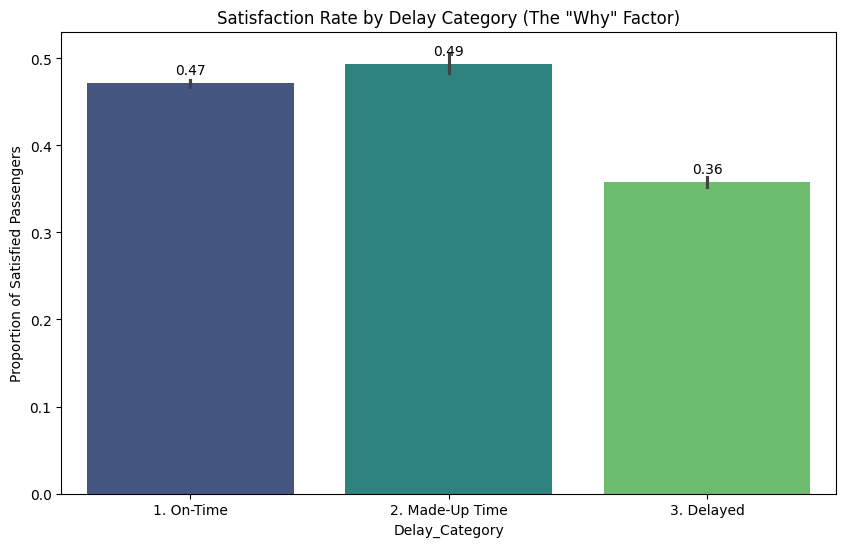

In [14]:
# 파생 변수 생성 함수
def classify_delay(row):
    dep = row['Departure Delay in Minutes']
    arr = row['Arrival Delay in Minutes']
    
    if dep <= 5 and arr <= 5: # 5분 이내는 정시로 간주
        return '1. On-Time'
    elif dep > 5 and arr <= 5: # 출발은 늦었으나 도착은 정시 (만회함!)
        return '2. Made-Up Time'
    elif dep > 5 and arr > 5: # 둘 다 늦음
        return '3. Delayed'
    else:
        return '4. Others' # 일찍 출발해서 늦게 도착 등

df['Delay_Category'] = df.apply(classify_delay, axis=1)

# 카테고리별 만족도 평균 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Delay_Category', y='satisfaction_binary', data=df, 
                 order=['1. On-Time', '2. Made-Up Time', '3. Delayed'], palette='viridis')

# 막대 위에 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.title('Satisfaction Rate by Delay Category (The "Why" Factor)')
plt.ylabel('Proportion of Satisfied Passengers')
plt.show()